In [1]:
import numpy as np
import pandas as pd

# Predict Air Pollution II - predict sequences

#### Exercise objectives
- Work with sequences of different lengths
- Use RNNs to return outputs for each observation in the sequences

<hr>

This exercise is a little bit different from the previous one: Here, you **observe _only_ the weather features (not the pollution)**, and you will **predict one value of air pollution *for each observation* in the input sequence**. 

What is the use-case? 
- Let's say that you have devices that are able to measure the air pollution in some places and to relate it to some weather features. That is fine! 
- But in another place, you have only weather measurements and no way to measure the air pollution.
- Then, you will use the relation between the weather features and the air pollution in some places to be able to predict the air pollution based on the weather features in another places. 

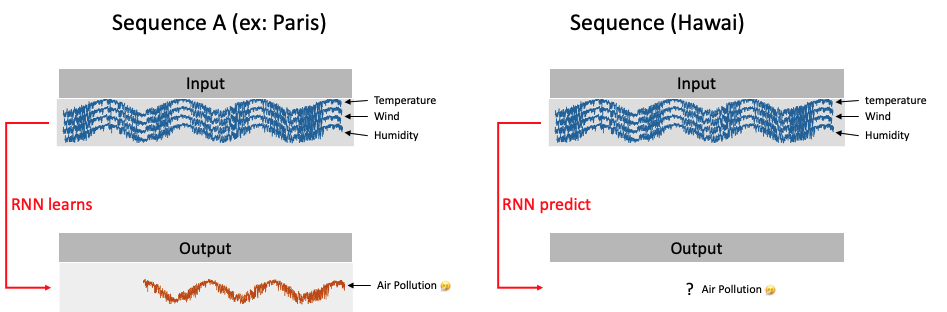

## 1. Data

👇 We load below the same dataset than in previous challenge. `pm2.5` is your target column. This time, it will not be a feature

In [2]:
df = pd.read_csv('data.txt', index_col=[0])
df = df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]
df

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
No,,,,,,,
1,NaN,-11.0,-21,1021.0,0,0,1.79
2,NaN,-12.0,-21,1020.0,0,0,4.92
3,NaN,-11.0,-21,1019.0,0,0,6.71
4,NaN,-14.0,-21,1019.0,0,0,9.84
5,NaN,-12.0,-20,1018.0,0,0,12.97
...,...,...,...,...,...,...,...
43820,8.0,-2.0,-23,1034.0,0,0,231.97
43821,10.0,-3.0,-22,1034.0,0,0,237.78
43822,10.0,-3.0,-22,1034.0,0,0,242.70


In [51]:
 df.iloc[:][['TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]

,TEMP,DEWP,PRES,Ir,Is,Iws
No,,,,,,
1,-11.0,-21,1021.0,0,0,1.79
2,-12.0,-21,1020.0,0,0,4.92
3,-11.0,-21,1019.0,0,0,6.71
4,-14.0,-21,1019.0,0,0,9.84
5,-12.0,-20,1018.0,0,0,12.97
...,...,...,...,...,...,...
43820,-2.0,-23,1034.0,0,0,231.97
43821,-3.0,-22,1034.0,0,0,237.78
43822,-3.0,-22,1034.0,0,0,242.70


We separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training. And the last 20% in the test set. We also scale the data so as to have them in the same range

In [3]:
# Time Serie split
test_size = int(20*len(df)/100)
df_train = df[:-test_size]
df_test = df[-test_size:]

In [40]:
# Scale with MinMaxScale
from sklearn.preprocessing import MinMaxScaler
columns = df.columns

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_train.columns

Index(['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws'], dtype='object')

## 2. Prepare sequences

### 2.1 Create (X,y)

Reuse your functions from previous challenge to answer this new one:

❓ **Question** ❓ Write a function `get_X_y(df, sequence_lengths)` that, given a input dataframe `df`, returns a dataset `(X, y)` where `X` are sequences of observations and `y` are their related pollution levels.

- Each observation corresponds to the weather features : TEMP, DEWP, PRES, Ir, Is, Iws. 
- If a sequence input contains `n` observations from Day `i` to Day `i+n`, then the corresponding values to predict are the sequence of pollution levels from Day `i` to Day `i+n` too.

❗ **Remark 1** In the last exercise, all the sequences had the same lengths. Here, they change with respect to the `sequence_lengths` argument, which is a list of integers:
- For instance, if `sequence_lengths = [7, 9, 6]`, $X$ will corresponds to three sequences: the first one with 7 observations, the second one with 9 observations and the third one with 6 observations.
- the length of `sequence_lengths` corresponds to the number of sequence you want to subsample from your initial sequence
- the $i$-th value of `sequence_lengths` corresponds to the length of the $i$-th sequence.

❗ **Remark 2** You are free to do whatever you want with the missing values that are in the inputs and outputs. The idea is not to spend much time on them but to get usable data.

In [102]:
# reuse functions from previous challenge

def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    start_indice = np.random.choice(len(df)-length+1, replace=False)
    all_indices = [x for x in range(start_indice,start_indice+length)]
    df_sample = df.take(all_indices)
    return df_sample

def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()

    # Case if ALL values of at least one feature of X are NaN,
    # then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)

    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)

    y_sample = df_subsample.iloc[0:length-1]['pm2.5']
    print(y_sample)
    # Case y_sample is NaN: redraw !
    if y_sample.isna().any(): # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample.iloc[0:length-1][['TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]
    print(X_sample)
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [103]:
def get_X_y(df, sequence_lengths):
    ''' returns a dataset `(X, y)` where `X` are a list of sequences of observations, and `y` are their related pollution levels'''
    X = []
    y = []
    for sequence in sequence_lengths:
        
        (X_sample, y_sample) = split_subsample_sequence(df, sequence)
        X.append(X_sample)
        y.append(y_sample)
    
    X = np.array(X)
    y = np.array(y)
        
    return X, y


In [104]:
a, b = get_X_y(df, [4,5,6])
a

No
35143    80.0
35144    86.0
35145    95.0
Name: pm2.5, dtype: float64
       TEMP  DEWP    PRES  Ir  Is   Iws
No                                     
35143  -6.0    -9  1025.0   0   0  1.79
35144  -4.0    -7  1025.0   0   0  0.89
35145  -3.0    -7  1025.0   0   0  0.89
No
43299    331.0
43300    303.0
43301    301.0
43302    306.0
Name: pm2.5, dtype: float64
       TEMP  DEWP    PRES  Ir  Is   Iws
No                                     
43299  -2.0    -5  1028.0   0   0  1.78
43300  -3.0    -5  1028.0   0   0  2.67
43301  -5.0    -7  1027.0   0   0  0.89
43302  -6.0    -7  1027.0   0   0  0.89
No
35901     71.0
35902     91.0
35903    109.0
35904    126.0
35905    104.0
Name: pm2.5, dtype: float64
       TEMP  DEWP    PRES  Ir  Is   Iws
No                                     
35901  -4.0   -27  1028.0   0   0  1.78
35902  -2.0   -27  1029.0   0   0  3.57
35903  -2.0   -27  1029.0   0   0  5.36
35904  -6.0   -24  1030.0   0   0  0.89
35905  -5.0   -22  1030.0   0   0  1.79


/var/folders/41/fr8r1hg95gl997_7cjm1cmk80000gn/T/ipykernel_2050/2560599048.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
/var/folders/41/fr8r1hg95gl997_7cjm1cmk80000gn/T/ipykernel_2050/2560599048.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


array([array([[-6.000e+00, -9.000e+00,  1.025e+03,  0.000e+00,  0.000e+00,
                1.790e+00],
              [-4.000e+00, -7.000e+00,  1.025e+03,  0.000e+00,  0.000e+00,
                8.900e-01],
              [-3.000e+00, -7.000e+00,  1.025e+03,  0.000e+00,  0.000e+00,
                8.900e-01]])                                              ,
       array([[-2.000e+00, -5.000e+00,  1.028e+03,  0.000e+00,  0.000e+00,
                1.780e+00],
              [-3.000e+00, -5.000e+00,  1.028e+03,  0.000e+00,  0.000e+00,
                2.670e+00],
              [-5.000e+00, -7.000e+00,  1.027e+03,  0.000e+00,  0.000e+00,
                8.900e-01],
              [-6.000e+00, -7.000e+00,  1.027e+03,  0.000e+00,  0.000e+00,
                8.900e-01]])                                              ,
       array([[-4.000e+00, -2.700e+01,  1.028e+03,  0.000e+00,  0.000e+00,
                1.780e+00],
              [-2.000e+00, -2.700e+01,  1.029e+03,  0.000e+00,  0.000e+00,
     

In [105]:
b

array([array([80., 86., 95.]), array([331., 303., 301., 306.]),
       array([ 71.,  91., 109., 126., 104.])], dtype=object)

👇 Test your code below

In [106]:
# Here we define the parameter to generate our train/test sets
train_size = 1000
test_size = round(0.2 * train_size)

min_seq_len = 15
max_seq_len = 30

In [138]:
# Let's generate some train/test sets
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)
X_train, y_train = get_X_y(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=test_size)
X_test, y_test = get_X_y(df_test, sequence_lengths_test)

2009    0.018109
2010    0.030181
2011    0.027163
2012    0.029175
2013    0.033199
2014    0.034205
2015    0.059356
2016    0.063380
2017    0.067404
2018    0.062374
2019    0.072435
2020    0.048290
2021    0.070423
2022    0.057344
2023    0.061368
Name: pm2.5, dtype: float64
          TEMP      DEWP      PRES   Ir   Is       Iws
2009  0.450000  0.278689  0.563636  0.0  0.0  0.004580
2010  0.433333  0.311475  0.545455  0.0  0.0  0.007639
2011  0.416667  0.344262  0.563636  0.0  0.0  0.000752
2012  0.400000  0.377049  0.581818  0.0  0.0  0.002290
2013  0.416667  0.377049  0.581818  0.0  0.0  0.000752
2014  0.400000  0.377049  0.581818  0.0  0.0  0.002273
2015  0.366667  0.442623  0.581818  0.0  0.0  0.003794
2016  0.350000  0.426230  0.581818  0.0  0.0  0.000752
2017  0.333333  0.442623  0.581818  0.0  0.0  0.000752
2018  0.333333  0.393443  0.581818  0.0  0.0  0.004580
2019  0.300000  0.360656  0.563636  0.0  0.0  0.000000
2020  0.300000  0.426230  0.563636  0.0  0.0  0.000769
20

18195    0.044266
18196    0.025151
18197    0.015091
18198    0.014085
18199    0.014085
18200    0.013078
18201    0.012072
18202    0.023139
18203    0.019115
18204    0.018109
18205    0.020121
18206    0.020121
18207    0.031187
18208    0.035211
18209    0.046278
18210    0.038229
18211    0.049296
18212    0.047284
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
18195  0.166667  0.245902  0.781818  0.0  0.0  0.006101
18196  0.200000  0.213115  0.781818  0.0  0.0  0.004580
18197  0.183333  0.213115  0.781818  0.0  0.0  0.011450
18198  0.183333  0.196721  0.781818  0.0  0.0  0.018320
18199  0.166667  0.196721  0.800000  0.0  0.0  0.023669
18200  0.183333  0.213115  0.818182  0.0  0.0  0.004580
18201  0.216667  0.213115  0.818182  0.0  0.0  0.004580
18202  0.250000  0.213115  0.818182  0.0  0.0  0.009929
18203  0.283333  0.196721  0.818182  0.0  0.0  0.012988
18204  0.300000  0.196721  0.781818  0.0  0.0  0.000752
18205  0.300000  0.196721  0.763

14211    0.009054
14212    0.008048
14213    0.008048
14214    0.017103
14215    0.021127
14216    0.016097
14217    0.017103
14218    0.013078
14219    0.007042
14220    0.007042
14221    0.011066
14222    0.007042
14223    0.004024
14224    0.004024
14225    0.008048
14226    0.017103
14227    0.024145
14228    0.035211
14229    0.032193
14230    0.037223
14231    0.045272
14232    0.045272
14233    0.051308
14234    0.067404
14235    0.068410
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
14211  0.700000  0.901639  0.218182  0.0  0.0  0.000752
14212  0.700000  0.885246  0.218182  0.0  0.0  0.006101
14213  0.700000  0.885246  0.218182  0.0  0.0  0.011450
14214  0.700000  0.885246  0.218182  0.0  0.0  0.018320
14215  0.716667  0.885246  0.218182  0.0  0.0  0.023669
14216  0.733333  0.885246  0.236364  0.0  0.0  0.030539
14217  0.766667  0.901639  0.236364  0.0  0.0  0.035888
14218  0.783333  0.885246  0.236364  0.0  0.0  0.042758
14219  0.816667  0

72    0.079477
73    0.058350
74    0.025151
75    0.026157
76    0.028169
77    0.026157
78    0.020121
79    0.029175
80    0.026157
81    0.027163
82    0.027163
83    0.025151
84    0.029175
85    0.032193
86    0.028169
87    0.029175
88    0.030181
89    0.030181
90    0.028169
91    0.026157
92    0.031187
93    0.033199
94    0.029175
95    0.031187
96    0.030181
97    0.034205
Name: pm2.5, dtype: float64
        TEMP      DEWP      PRES   Ir   Is       Iws
72  0.116667  0.311475  0.581818  0.0  0.0  0.026728
73  0.166667  0.278689  0.581818  0.0  0.0  0.036657
74  0.150000  0.262295  0.600000  0.0  0.0  0.050414
75  0.133333  0.245902  0.600000  0.0  0.0  0.067214
76  0.133333  0.229508  0.618182  0.0  0.0  0.082492
77  0.116667  0.213115  0.636364  0.0  0.0  0.094711
78  0.116667  0.196721  0.654545  0.0  0.0  0.109989
79  0.100000  0.196721  0.654545  0.0  0.0  0.125267
80  0.100000  0.180328  0.672727  0.0  0.0  0.137486
81  0.100000  0.180328  0.690909  0.0  0.0  0.154285

22993    0.090543
22994    0.096579
22995    0.088531
22996    0.086519
22997    0.065392
22998    0.083501
22999    0.097586
23000    0.108652
23001    0.096579
23002    0.102616
23003    0.078471
23004    0.060362
23005    0.052314
23006    0.053320
23007         NaN
Name: pm2.5, dtype: float64
30773    0.066398
30774    0.074447
30775    0.093561
30776    0.117706
30777    0.119718
30778    0.112676
30779    0.057344
30780    0.048290
30781    0.044266
30782    0.042254
30783    0.043260
30784    0.045272
30785    0.045272
30786    0.064386
30787    0.060362
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
30773  0.716667  0.885246  0.181818  0.0  0.0  0.002290
30774  0.733333  0.885246  0.181818  0.0  0.0  0.005349
30775  0.750000  0.901639  0.200000  0.0  0.0  0.008408
30776  0.783333  0.901639  0.200000  0.0  0.0  0.000752
30777  0.800000  0.901639  0.200000  0.0  0.0  0.002290
30778  0.833333  0.901639  0.200000  0.0  0.0  0.002290
30779  0.850

31616    0.039235
31617    0.046278
31618    0.062374
31619    0.104628
31620    0.115694
31621    0.117706
31622    0.113682
31623    0.128773
31624    0.132797
31625    0.116700
31626    0.093561
31627    0.100604
31628    0.111670
31629    0.109658
31630    0.093561
31631    0.080483
31632    0.074447
31633    0.070423
31634    0.080483
31635    0.106640
31636    0.141851
31637    0.173038
31638    0.179074
31639    0.204225
31640    0.209256
31641    0.176056
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES        Ir   Is       Iws
31616  0.750000  0.868852  0.254545  0.000000  0.0  0.006101
31617  0.766667  0.885246  0.272727  0.000000  0.0  0.000752
31618  0.783333  0.885246  0.272727  0.000000  0.0  0.002273
31619  0.816667  0.934426  0.254545  0.000000  0.0  0.003794
31620  0.850000  0.934426  0.254545  0.000000  0.0  0.002290
31621  0.866667  0.934426  0.236364  0.000000  0.0  0.005349
31622  0.883333  0.934426  0.236364  0.000000  0.0  0.002290
31623  0.900000 

17261    0.011066
17262    0.013078
17263    0.013078
17264    0.017103
17265    0.012072
17266    0.018109
17267    0.017103
17268         NaN
17269    0.018109
17270    0.019115
17271    0.014085
17272    0.014085
17273    0.013078
17274    0.010060
17275    0.009054
17276    0.012072
17277    0.018109
17278    0.014085
Name: pm2.5, dtype: float64
18266    0.013078
18267    0.009054
18268    0.011066
18269    0.012072
18270    0.011066
18271    0.013078
18272    0.013078
18273    0.013078
18274    0.014085
18275    0.014085
18276    0.014085
18277    0.012072
18278    0.013078
18279    0.016097
18280    0.016097
18281    0.017103
18282    0.023139
18283    0.025151
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
18266  0.133333  0.098361  0.781818  0.0  0.0  0.007639
18267  0.133333  0.098361  0.781818  0.0  0.0  0.016047
18268  0.133333  0.098361  0.781818  0.0  0.0  0.024455
18269  0.100000  0.098361  0.781818  0.0  0.0  0.031325
18270  0.100000 

31462    0.057344
31463    0.063380
31464    0.076459
31465    0.075453
31466    0.084507
31467    0.090543
31468    0.086519
31469    0.100604
31470    0.103622
31471    0.109658
31472    0.110664
31473    0.107646
31474    0.063380
31475    0.066398
31476    0.058350
31477    0.076459
31478    0.080483
31479    0.075453
31480    0.062374
31481    0.096579
31482    0.122736
31483    0.170020
31484    0.144869
31485    0.021127
31486    0.021127
31487    0.028169
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES        Ir   Is       Iws
31462  0.750000  0.868852  0.218182  0.000000  0.0  0.061882
31463  0.766667  0.868852  0.218182  0.000000  0.0  0.067231
31464  0.750000  0.885246  0.200000  0.000000  0.0  0.072580
31465  0.750000  0.885246  0.200000  0.000000  0.0  0.000752
31466  0.733333  0.885246  0.181818  0.000000  0.0  0.002290
31467  0.716667  0.885246  0.181818  0.000000  0.0  0.002290
31468  0.700000  0.885246  0.181818  0.000000  0.0  0.000752
31469  0.700000 

17302    0.068410
17303    0.070423
17304    0.095573
17305    0.118712
17306    0.117706
17307    0.119718
17308    0.106640
17309    0.098592
17310    0.073441
17311    0.076459
17312    0.087525
17313    0.098592
17314    0.090543
17315    0.070423
17316    0.063380
17317    0.033199
17318    0.015091
17319    0.018109
17320    0.016097
17321    0.018109
17322    0.008048
17323    0.016097
17324    0.017103
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
17302  0.200000  0.278689  0.690909  0.0  0.0  0.000752
17303  0.183333  0.278689  0.690909  0.0  0.0  0.000752
17304  0.183333  0.295082  0.690909  0.0  0.0  0.002273
17305  0.183333  0.295082  0.672727  0.0  0.0  0.000752
17306  0.166667  0.311475  0.672727  0.0  0.0  0.000752
17307  0.150000  0.295082  0.654545  0.0  0.0  0.002290
17308  0.166667  0.311475  0.636364  0.0  0.0  0.003811
17309  0.166667  0.295082  0.636364  0.0  0.0  0.006870
17310  0.133333  0.278689  0.636364  0.0  0.0  0.01221

6270    0.055332
6271    0.084507
6272    0.106640
6273    0.073441
6274    0.087525
6275    0.118712
6276    0.138833
6277    0.118712
6278    0.079477
6279    0.070423
6280    0.049296
6281    0.037223
6282    0.047284
6283         NaN
6284         NaN
6285         NaN
Name: pm2.5, dtype: float64
14082         NaN
14083         NaN
14084         NaN
14085    0.058350
14086    0.054326
14087    0.070423
14088    0.074447
14089    0.064386
14090    0.082495
14091    0.119718
14092    0.146881
14093    0.121730
14094    0.064386
14095    0.051308
14096    0.061368
14097    0.083501
Name: pm2.5, dtype: float64
20477    0.085513
20478    0.080483
20479    0.058350
20480    0.061368
20481    0.070423
20482    0.057344
20483    0.064386
20484    0.057344
20485    0.060362
20486    0.046278
20487    0.049296
20488    0.045272
20489    0.009054
20490    0.018109
20491    0.026157
20492    0.019115
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
20477  0.533

10252    0.046278
10253    0.052314
10254    0.069416
10255    0.105634
10256    0.083501
10257    0.051308
10258    0.043260
10259    0.057344
10260    0.057344
10261    0.055332
10262    0.051308
10263    0.046278
10264    0.042254
10265    0.055332
10266    0.058350
10267    0.068410
10268    0.091549
10269    0.089537
10270    0.059356
10271    0.066398
10272    0.069416
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
10252  0.233333  0.377049  0.618182  0.0  0.0  0.002290
10253  0.266667  0.377049  0.618182  0.0  0.0  0.003811
10254  0.233333  0.377049  0.618182  0.0  0.0  0.000752
10255  0.266667  0.377049  0.618182  0.0  0.0  0.002290
10256  0.300000  0.393443  0.618182  0.0  0.0  0.000752
10257  0.383333  0.377049  0.618182  0.0  0.0  0.000752
10258  0.400000  0.344262  0.618182  0.0  0.0  0.002290
10259  0.450000  0.344262  0.618182  0.0  0.0  0.000752
10260  0.466667  0.327869  0.600000  0.0  0.0  0.002290
10261  0.483333  0.344262  0.56363

27829    0.182093
27830    0.188129
27831    0.205231
27832    0.219316
27833    0.223340
27834    0.209256
27835    0.226358
27836    0.236419
27837    0.264588
27838    0.275654
27839    0.276660
27840    0.303823
27841    0.226358
27842    0.221328
27843    0.208249
27844    0.203219
27845    0.201207
27846    0.207243
27847    0.203219
27848    0.204225
27849    0.197183
27850    0.189135
27851    0.188129
27852    0.205231
27853    0.234406
27854    0.260563
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
27829  0.516667  0.393443  0.436364  0.0  0.0  0.008357
27830  0.533333  0.377049  0.418182  0.0  0.0  0.011416
27831  0.550000  0.393443  0.400000  0.0  0.0  0.004580
27832  0.550000  0.393443  0.400000  0.0  0.0  0.007639
27833  0.516667  0.409836  0.400000  0.0  0.0  0.002290
27834  0.450000  0.426230  0.400000  0.0  0.0  0.000000
27835  0.400000  0.442623  0.418182  0.0  0.0  0.001521
27836  0.416667  0.426230  0.418182  0.0  0.0  0.003042


12533    0.205231
12534    0.218310
12535    0.207243
12536    0.242455
12537    0.238431
12538    0.232394
12539    0.178068
12540    0.160966
12541    0.152918
12542    0.102616
12543    0.066398
12544    0.069416
12545    0.069416
12546    0.082495
12547    0.037223
12548    0.047284
12549    0.055332
12550    0.058350
12551    0.059356
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES        Ir   Is       Iws
12533  0.616667  0.819672  0.127273  0.000000  0.0  0.000752
12534  0.633333  0.836066  0.127273  0.000000  0.0  0.000752
12535  0.700000  0.819672  0.127273  0.000000  0.0  0.003811
12536  0.716667  0.836066  0.127273  0.000000  0.0  0.000752
12537  0.766667  0.836066  0.127273  0.000000  0.0  0.002290
12538  0.816667  0.819672  0.109091  0.000000  0.0  0.005349
12539  0.850000  0.803279  0.109091  0.000000  0.0  0.000752
12540  0.883333  0.803279  0.090909  0.000000  0.0  0.004580
12541  0.883333  0.803279  0.054545  0.000000  0.0  0.012988
12542  0.900000  0.8

30042    0.208249
30043    0.226358
30044    0.197183
30045    0.193159
30046    0.179074
30047    0.174044
30048    0.176056
30049    0.163984
30050    0.164990
30051    0.165996
30052    0.177062
30053    0.167002
30054    0.164990
30055    0.134809
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES        Ir   Is       Iws
30042  0.633333  0.819672  0.363636  0.000000  0.0  0.000752
30043  0.633333  0.819672  0.363636  0.000000  0.0  0.002290
30044  0.633333  0.819672  0.363636  0.000000  0.0  0.005349
30045  0.633333  0.819672  0.381818  0.000000  0.0  0.000752
30046  0.633333  0.819672  0.381818  0.000000  0.0  0.002273
30047  0.633333  0.819672  0.381818  0.000000  0.0  0.002290
30048  0.633333  0.819672  0.400000  0.000000  0.0  0.000752
30049  0.633333  0.819672  0.381818  0.000000  0.0  0.000752
30050  0.633333  0.819672  0.363636  0.000000  0.0  0.000752
30051  0.633333  0.819672  0.345455  0.000000  0.0  0.002290
30052  0.633333  0.819672  0.363636  0.000000  0.

12795    0.195171
12796    0.213280
12797    0.258551
12798    0.245473
12799    0.258551
12800    0.228370
12801    0.199195
12802    0.181087
12803    0.154930
12804    0.132797
12805    0.106640
12806    0.095573
12807    0.101610
12808    0.110664
12809    0.099598
12810    0.113682
12811    0.147887
12812    0.270624
12813    0.286720
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
12795  0.666667  0.852459  0.290909  0.0  0.0  0.000752
12796  0.650000  0.852459  0.309091  0.0  0.0  0.002273
12797  0.650000  0.852459  0.309091  0.0  0.0  0.000752
12798  0.650000  0.852459  0.309091  0.0  0.0  0.002273
12799  0.700000  0.868852  0.309091  0.0  0.0  0.000000
12800  0.716667  0.885246  0.290909  0.0  0.0  0.001521
12801  0.750000  0.868852  0.290909  0.0  0.0  0.003042
12802  0.783333  0.868852  0.290909  0.0  0.0  0.004563
12803  0.816667  0.852459  0.290909  0.0  0.0  0.006084
12804  0.833333  0.868852  0.290909  0.0  0.0  0.002290
12805  0.85000

28787    0.034205
28788    0.059356
28789    0.053320
28790    0.045272
28791    0.038229
28792    0.039235
28793    0.045272
28794    0.042254
28795    0.043260
28796    0.050302
28797    0.048290
28798    0.056338
28799    0.063380
28800    0.059356
28801    0.053320
28802    0.042254
28803    0.044266
28804    0.050302
28805    0.065392
28806    0.070423
28807    0.073441
28808    0.071429
28809    0.062374
28810    0.073441
28811    0.073441
28812    0.078471
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
28787  0.550000  0.327869  0.400000  0.0  0.0  0.000752
28788  0.566667  0.459016  0.363636  0.0  0.0  0.004580
28789  0.566667  0.459016  0.345455  0.0  0.0  0.011450
28790  0.583333  0.442623  0.327273  0.0  0.0  0.018320
28791  0.583333  0.459016  0.309091  0.0  0.0  0.028249
28792  0.600000  0.442623  0.290909  0.0  0.0  0.038178
28793  0.583333  0.442623  0.272727  0.0  0.0  0.046586
28794  0.566667  0.459016  0.254545  0.0  0.0  0.054994


6420   NaN
6421   NaN
6422   NaN
6423   NaN
6424   NaN
6425   NaN
6426   NaN
6427   NaN
6428   NaN
6429   NaN
6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
6435   NaN
6436   NaN
6437   NaN
6438   NaN
6439   NaN
6440   NaN
6441   NaN
6442   NaN
6443   NaN
6444   NaN
6445   NaN
6446   NaN
6447   NaN
Name: pm2.5, dtype: float64
26988    0.486922
26989    0.465795
26990    0.478873
26991    0.447686
26992    0.443662
26993    0.438632
26994    0.413481
26995    0.391348
26996    0.359155
26997    0.347082
26998    0.337022
26999    0.323944
27000    0.317907
27001    0.316901
27002    0.305835
27003    0.283702
27004    0.261569
27005    0.267606
27006    0.279678
27007    0.274648
27008    0.276660
27009    0.288732
27010    0.303823
27011    0.300805
27012    0.298793
27013    0.287726
27014    0.298793
27015    0.289738
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir        Is       Iws
26988  0.250000  0.475410  0.618182  0.0  0.111111  0.000752
26989  0.2

20758    0.037223
20759    0.037223
20760    0.043260
20761    0.044266
20762    0.036217
20763    0.047284
20764    0.046278
20765    0.051308
20766    0.051308
20767    0.041247
20768    0.037223
20769    0.033199
20770    0.038229
20771    0.042254
20772    0.027163
20773    0.038229
20774    0.037223
20775    0.028169
20776    0.016097
20777    0.022133
20778    0.016097
20779    0.019115
20780    0.012072
20781    0.022133
20782    0.036217
20783    0.031187
20784    0.040241
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
20758  0.566667  0.475410  0.309091  0.0  0.0  0.113014
20759  0.566667  0.475410  0.309091  0.0  0.0  0.118363
20760  0.600000  0.442623  0.309091  0.0  0.0  0.125233
20761  0.566667  0.557377  0.309091  0.0  0.0  0.000752
20762  0.550000  0.508197  0.309091  0.0  0.0  0.002290
20763  0.583333  0.475410  0.290909  0.0  0.0  0.005349
20764  0.533333  0.508197  0.290909  0.0  0.0  0.008408
20765  0.483333  0.540984  0.290909  0

4520    0.074447
4521    0.077465
4522    0.071429
4523    0.049296
4524    0.031187
4525    0.028169
4526    0.021127
4527    0.021127
4528    0.014085
4529    0.023139
4530    0.031187
4531    0.032193
4532    0.032193
4533    0.033199
4534    0.070423
4535    0.073441
4536    0.069416
4537    0.086519
4538    0.081489
4539    0.067404
4540    0.069416
4541    0.069416
4542    0.079477
4543    0.084507
4544    0.079477
Name: pm2.5, dtype: float64
          TEMP      DEWP      PRES   Ir   Is       Iws
4520  0.766667  0.819672  0.309091  0.0  0.0  0.002290
4521  0.800000  0.819672  0.309091  0.0  0.0  0.005349
4522  0.833333  0.803279  0.290909  0.0  0.0  0.004580
4523  0.866667  0.770492  0.272727  0.0  0.0  0.009929
4524  0.900000  0.737705  0.254545  0.0  0.0  0.002290
4525  0.900000  0.721311  0.236364  0.0  0.0  0.005349
4526  0.916667  0.721311  0.236364  0.0  0.0  0.002290
4527  0.916667  0.721311  0.218182  0.0  0.0  0.007639
4528  0.933333  0.721311  0.218182  0.0  0.0  0.0045

10355    0.016097
10356    0.017103
10357    0.019115
10358    0.016097
10359    0.021127
10360    0.024145
10361    0.024145
10362    0.016097
10363    0.015091
10364    0.018109
10365    0.014085
10366    0.010060
10367    0.007042
10368         NaN
10369    0.006036
10370    0.007042
10371    0.007042
10372    0.009054
Name: pm2.5, dtype: float64
30958    0.140845
30959    0.131791
30960    0.094567
30961    0.094567
30962    0.092555
30963    0.101610
30964    0.099598
30965    0.113682
30966    0.136821
30967    0.162978
30968    0.127767
30969    0.093561
30970    0.083501
30971    0.071429
30972    0.073441
30973    0.080483
30974    0.075453
30975    0.067404
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
30958  0.766667  0.901639  0.290909  0.0  0.0  0.055781
30959  0.750000  0.885246  0.290909  0.0  0.0  0.061130
30960  0.733333  0.885246  0.290909  0.0  0.0  0.064189
30961  0.733333  0.885246  0.290909  0.0  0.0  0.069538
30962  0.733333 

11255         NaN
11256    0.053320
11257         NaN
11258         NaN
11259         NaN
11260         NaN
11261         NaN
11262         NaN
11263         NaN
11264         NaN
11265         NaN
11266         NaN
11267         NaN
11268         NaN
11269    0.028169
11270    0.026157
11271    0.027163
11272    0.025151
11273         NaN
11274         NaN
11275         NaN
11276         NaN
Name: pm2.5, dtype: float64
3834    0.060362
3835    0.041247
3836    0.040241
3837    0.032193
3838    0.051308
3839    0.042254
3840    0.042254
3841    0.038229
3842    0.043260
3843    0.063380
3844    0.063380
3845    0.062374
3846    0.060362
3847    0.046278
3848    0.041247
3849    0.042254
3850    0.039235
3851    0.036217
3852    0.034205
3853    0.047284
3854    0.036217
3855    0.040241
Name: pm2.5, dtype: float64
          TEMP      DEWP      PRES        Ir   Is       Iws
3834  0.800000  0.754098  0.381818  0.000000  0.0  0.018320
3835  0.783333  0.754098  0.400000  0.000000  0.0  0.0

30647    0.112676
30648    0.155936
30649    0.144869
30650    0.141851
30651    0.156942
30652    0.147887
30653    0.154930
30654    0.153924
30655    0.152918
30656    0.144869
30657    0.147887
30658    0.143863
30659    0.150905
30660    0.160966
30661    0.173038
30662    0.184105
30663    0.196177
30664    0.192153
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES        Ir   Is       Iws
30647  0.733333  0.918033  0.218182  0.000000  0.0  0.002273
30648  0.733333  0.918033  0.200000  0.000000  0.0  0.003794
30649  0.733333  0.901639  0.181818  0.000000  0.0  0.005315
30650  0.716667  0.901639  0.163636  0.000000  0.0  0.004580
30651  0.716667  0.901639  0.163636  0.027778  0.0  0.000752
30652  0.716667  0.901639  0.163636  0.000000  0.0  0.000752
30653  0.716667  0.901639  0.163636  0.000000  0.0  0.000000
30654  0.716667  0.901639  0.163636  0.000000  0.0  0.001521
30655  0.733333  0.901639  0.181818  0.000000  0.0  0.002290
30656  0.733333  0.901639  0.181818  0

31649    0.055332
31650    0.047284
31651    0.058350
31652    0.062374
31653    0.057344
31654    0.058350
31655    0.060362
31656    0.057344
31657    0.061368
31658    0.067404
31659    0.056338
31660    0.048290
31661    0.042254
31662    0.038229
31663    0.042254
31664    0.051308
31665    0.050302
31666    0.048290
31667    0.056338
31668    0.047284
31669    0.050302
31670    0.053320
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES        Ir   Is       Iws
31649  0.766667  0.934426  0.236364  0.083333  0.0  0.000752
31650  0.733333  0.901639  0.236364  0.111111  0.0  0.007639
31651  0.750000  0.901639  0.254545  0.000000  0.0  0.014509
31652  0.733333  0.901639  0.272727  0.027778  0.0  0.004580
31653  0.750000  0.885246  0.272727  0.000000  0.0  0.004580
31654  0.716667  0.901639  0.254545  0.027778  0.0  0.002290
31655  0.733333  0.885246  0.236364  0.055556  0.0  0.005349
31656  0.733333  0.918033  0.236364  0.000000  0.0  0.012219
31657  0.716667  0.901639  

2877    0.039235
2878    0.045272
2879    0.054326
2880    0.062374
2881    0.070423
2882    0.066398
2883    0.070423
2884    0.082495
2885    0.097586
2886    0.086519
2887    0.094567
2888    0.089537
2889    0.090543
2890    0.086519
2891    0.070423
Name: pm2.5, dtype: float64
          TEMP      DEWP      PRES   Ir   Is       Iws
2877  0.633333  0.491803  0.345455  0.0  0.0  0.047372
2878  0.633333  0.491803  0.345455  0.0  0.0  0.061130
2879  0.616667  0.491803  0.345455  0.0  0.0  0.066479
2880  0.583333  0.508197  0.345455  0.0  0.0  0.000752
2881  0.533333  0.540984  0.327273  0.0  0.0  0.000752
2882  0.466667  0.557377  0.327273  0.0  0.0  0.000752
2883  0.450000  0.557377  0.327273  0.0  0.0  0.002273
2884  0.450000  0.557377  0.327273  0.0  0.0  0.000752
2885  0.450000  0.573770  0.309091  0.0  0.0  0.002273
2886  0.450000  0.573770  0.327273  0.0  0.0  0.005332
2887  0.533333  0.573770  0.327273  0.0  0.0  0.008391
2888  0.583333  0.540984  0.327273  0.0  0.0  0.000752
28

11809    0.080483
11810    0.088531
11811    0.062374
11812    0.054326
11813    0.066398
11814    0.064386
11815    0.079477
11816    0.082495
11817    0.080483
11818    0.063380
11819    0.054326
11820    0.059356
11821    0.053320
11822    0.039235
11823    0.040241
11824    0.042254
11825    0.046278
11826    0.044266
11827    0.041247
11828    0.058350
11829    0.063380
11830    0.065392
11831    0.061368
11832    0.076459
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES        Ir   Is       Iws
11809  0.566667  0.655738  0.381818  0.000000  0.0  0.062634
11810  0.566667  0.655738  0.381818  0.000000  0.0  0.065693
11811  0.550000  0.639344  0.381818  0.000000  0.0  0.068752
11812  0.550000  0.639344  0.381818  0.000000  0.0  0.000752
11813  0.550000  0.639344  0.400000  0.000000  0.0  0.000752
11814  0.550000  0.639344  0.400000  0.000000  0.0  0.002273
11815  0.566667  0.655738  0.400000  0.000000  0.0  0.003794
11816  0.616667  0.655738  0.400000  0.000000  0.0  

26837    0.426559
26838    0.419517
26839    0.424547
26840    0.396378
26841    0.390342
26842    0.403421
26843    0.404427
26844    0.398390
26845    0.397384
26846    0.394366
26847    0.361167
26848    0.302817
26849    0.274648
26850    0.298793
26851    0.322938
26852    0.338028
26853    0.401408
26854    0.380282
26855    0.400402
26856    0.256539
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir        Is       Iws
26837  0.233333  0.426230  0.527273  0.0  0.000000  0.002273
26838  0.233333  0.442623  0.527273  0.0  0.000000  0.003794
26839  0.233333  0.426230  0.527273  0.0  0.000000  0.000752
26840  0.233333  0.442623  0.527273  0.0  0.000000  0.000752
26841  0.233333  0.442623  0.509091  0.0  0.000000  0.000752
26842  0.233333  0.442623  0.509091  0.0  0.037037  0.000752
26843  0.250000  0.442623  0.509091  0.0  0.074074  0.002273
26844  0.250000  0.442623  0.490909  0.0  0.000000  0.002290
26845  0.250000  0.442623  0.472727  0.0  0.000000  0.005349
26

9108    0.012072
9109    0.017103
9110    0.017103
9111    0.017103
9112    0.014085
9113    0.015091
9114    0.015091
9115    0.021127
9116    0.027163
9117    0.017103
9118    0.029175
9119    0.033199
9120    0.029175
9121    0.024145
9122    0.016097
9123    0.014085
9124    0.013078
9125    0.013078
9126    0.013078
9127    0.019115
9128    0.011066
Name: pm2.5, dtype: float64
          TEMP      DEWP      PRES   Ir   Is       Iws
9108  0.216667  0.131148  0.890909  0.0  0.0  0.491224
9109  0.233333  0.147541  0.872727  0.0  0.0  0.506503
9110  0.250000  0.131148  0.854545  0.0  0.0  0.523302
9111  0.250000  0.147541  0.854545  0.0  0.0  0.537059
9112  0.250000  0.163934  0.836364  0.0  0.0  0.550816
9113  0.250000  0.163934  0.836364  0.0  0.0  0.563035
9114  0.233333  0.163934  0.854545  0.0  0.0  0.572964
9115  0.183333  0.163934  0.854545  0.0  0.0  0.578313
9116  0.183333  0.163934  0.854545  0.0  0.0  0.000752
9117  0.183333  0.131148  0.854545  0.0  0.0  0.002290
9118  0.15

25272    0.011066
25273    0.007042
25274    0.009054
25275    0.010060
25276    0.006036
25277    0.012072
25278    0.013078
25279    0.014085
25280    0.022133
25281    0.027163
25282    0.020121
25283    0.022133
25284    0.024145
25285    0.023139
25286    0.022133
25287    0.031187
25288    0.036217
25289    0.036217
25290    0.051308
25291    0.067404
25292         NaN
Name: pm2.5, dtype: float64
10498    0.018109
10499    0.013078
10500    0.025151
10501    0.022133
10502    0.021127
10503    0.023139
10504    0.025151
10505    0.017103
10506    0.012072
10507    0.016097
10508    0.018109
10509    0.017103
10510    0.017103
10511    0.014085
10512    0.016097
10513    0.017103
10514    0.009054
10515    0.009054
10516    0.009054
10517    0.011066
10518    0.014085
Name: pm2.5, dtype: float64
           TEMP      DEWP      PRES   Ir   Is       Iws
10498  0.416667  0.229508  0.727273  0.0  0.0  0.091669
10499  0.433333  0.229508  0.709091  0.0  0.0  0.105426
10500  0.450000  0.2

/var/folders/41/fr8r1hg95gl997_7cjm1cmk80000gn/T/ipykernel_2050/2560599048.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
/var/folders/41/fr8r1hg95gl997_7cjm1cmk80000gn/T/ipykernel_2050/2560599048.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


4109    0.070423
4110    0.070423
4111    0.071429
4112    0.076459
4113    0.072435
4114    0.060362
4115    0.064386
4116    0.073441
4117    0.070423
4118    0.074447
4119    0.057344
4120    0.062374
4121    0.061368
4122    0.054326
4123    0.051308
4124    0.053320
4125    0.057344
4126    0.066398
4127    0.066398
4128    0.015091
4129    0.018109
4130    0.018109
4131    0.015091
Name: pm2.5, dtype: float64
          TEMP      DEWP      PRES        Ir   Is       Iws
4109  0.650000  0.836066  0.327273  0.000000  0.0  0.033615
4110  0.650000  0.836066  0.327273  0.000000  0.0  0.035136
4111  0.650000  0.836066  0.327273  0.000000  0.0  0.036657
4112  0.650000  0.836066  0.309091  0.000000  0.0  0.039716
4113  0.650000  0.836066  0.327273  0.000000  0.0  0.000752
4114  0.650000  0.836066  0.327273  0.000000  0.0  0.002273
4115  0.666667  0.836066  0.327273  0.000000  0.0  0.000752
4116  0.666667  0.836066  0.345455  0.000000  0.0  0.003811
4117  0.683333  0.836066  0.345455  0.000

4739    0.135815
4740    0.142857
4741    0.144869
4742    0.142857
4743    0.139839
4744    0.129779
4745    0.132797
4746    0.130785
4747    0.162978
4748    0.162978
4749    0.163984
4750    0.152918
4751    0.150905
4752    0.160966
4753    0.173038
4754    0.189135
4755    0.196177
4756    0.221328
4757    0.192153
4758    0.154930
4759    0.158954
4760    0.131791
4761    0.128773
4762    0.123742
Name: pm2.5, dtype: float64
          TEMP      DEWP      PRES   Ir   Is       Iws
4739  0.716667  0.868852  0.272727  0.0  0.0  0.003042
4740  0.716667  0.885246  0.272727  0.0  0.0  0.004563
4741  0.750000  0.885246  0.272727  0.0  0.0  0.002290
4742  0.750000  0.885246  0.272727  0.0  0.0  0.002290
4743  0.783333  0.885246  0.272727  0.0  0.0  0.005349
4744  0.783333  0.885246  0.272727  0.0  0.0  0.008408
4745  0.800000  0.885246  0.254545  0.0  0.0  0.015278
4746  0.783333  0.901639  0.254545  0.0  0.0  0.023686
4747  0.783333  0.901639  0.254545  0.0  0.0  0.029035
4748  0.783333

2492         NaN
2493         NaN
2494    0.225352
2495    0.247485
2496    0.253521
2497    0.275654
2498    0.188129
2499    0.080483
2500    0.056338
2501    0.055332
2502    0.055332
2503    0.057344
2504    0.067404
2505    0.069416
2506    0.078471
2507    0.083501
2508    0.105634
2509    0.112676
2510    0.104628
2511    0.103622
2512    0.093561
Name: pm2.5, dtype: float64
5015    0.077465
5016    0.089537
5017    0.088531
5018    0.083501
5019    0.089537
5020    0.096579
5021    0.090543
5022    0.099598
5023    0.101610
5024    0.114688
5025    0.135815
5026    0.155936
5027    0.190141
5028    0.180080
5029    0.151911
5030    0.125755
5031    0.101610
5032    0.092555
5033    0.097586
5034    0.086519
5035    0.084507
Name: pm2.5, dtype: float64
          TEMP      DEWP      PRES   Ir   Is       Iws
5015  0.866667  0.868852  0.200000  0.0  0.0  0.080954
5016  0.850000  0.852459  0.200000  0.0  0.0  0.089362
5017  0.833333  0.868852  0.218182  0.0  0.0  0.094711
5018  0.78

2060    0.082495
2061    0.085513
2062    0.095573
2063    0.096579
2064    0.107646
2065    0.111670
2066    0.125755
2067    0.123742
2068    0.145875
2069    0.153924
2070    0.159960
2071    0.154930
2072    0.192153
2073    0.196177
2074    0.195171
2075    0.194165
2076    0.176056
2077    0.195171
2078    0.165996
2079    0.138833
2080    0.100604
2081    0.083501
2082    0.053320
2083    0.052314
2084    0.060362
2085    0.100604
Name: pm2.5, dtype: float64
          TEMP      DEWP      PRES        Ir   Is       Iws
2060  0.566667  0.540984  0.345455  0.000000  0.0  0.000752
2061  0.566667  0.540984  0.345455  0.000000  0.0  0.000752
2062  0.566667  0.557377  0.327273  0.000000  0.0  0.004580
2063  0.550000  0.590164  0.327273  0.000000  0.0  0.009929
2064  0.533333  0.590164  0.327273  0.000000  0.0  0.012988
2065  0.533333  0.590164  0.327273  0.000000  0.0  0.016047
2066  0.533333  0.590164  0.327273  0.000000  0.0  0.000752
2067  0.533333  0.573770  0.327273  0.000000  0.0 

3268    0.074447
3269    0.071429
3270    0.080483
3271    0.079477
3272    0.076459
3273    0.069416
3274    0.068410
3275    0.094567
3276    0.096579
3277    0.098592
3278    0.098592
3279    0.109658
3280    0.095573
3281    0.087525
3282    0.090543
3283    0.069416
3284    0.054326
3285    0.052314
3286    0.048290
3287    0.040241
3288    0.041247
3289    0.021127
3290    0.028169
3291    0.028169
3292    0.034205
3293    0.058350
3294    0.064386
3295    0.068410
Name: pm2.5, dtype: float64
          TEMP      DEWP      PRES        Ir   Is       Iws
3268  0.616667  0.639344  0.400000  0.000000  0.0  0.000752
3269  0.616667  0.639344  0.400000  0.000000  0.0  0.002273
3270  0.616667  0.622951  0.400000  0.000000  0.0  0.002290
3271  0.583333  0.639344  0.400000  0.000000  0.0  0.000000
3272  0.566667  0.655738  0.400000  0.000000  0.0  0.000752
3273  0.566667  0.672131  0.400000  0.000000  0.0  0.002273
3274  0.566667  0.672131  0.418182  0.000000  0.0  0.003794
3275  0.616667  

/var/folders/41/fr8r1hg95gl997_7cjm1cmk80000gn/T/ipykernel_2050/2560599048.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
/var/folders/41/fr8r1hg95gl997_7cjm1cmk80000gn/T/ipykernel_2050/2560599048.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


In [137]:
y_test

array([array([0.10462777, 0.09255533, 0.05533199, 0.02716298, 0.03018109,
              0.02716298, 0.02112676, 0.02515091, 0.02313883, 0.02816901,
              0.02917505, 0.03118712, 0.03822938, 0.03923541, 0.06136821,
              0.04225352, 0.0472837 , 0.05231388, 0.0472837 , 0.04225352,
              0.04828974, 0.05231388, 0.04828974, 0.05935614, 0.04828974]),
       array([0.0945674 , 0.10362173, 0.10160966, 0.11468813, 0.12374245,
              0.12273642, 0.09657948, 0.05130785, 0.02313883, 0.05935614,
              0.04325956, 0.01307847, 0.01307847, 0.01609658, 0.01307847,
              0.01207243, 0.01810865, 0.01609658, 0.01509054, 0.02012072,
              0.01710262, 0.01911469])                                   ,
       array([0.10865191, 0.11267606, 0.11871227, 0.09255533, 0.07444668,
              0.05030181, 0.0362173 , 0.03018109, 0.03822938, 0.0362173 ,
              0.04325956, 0.04828974, 0.05734406, 0.06539235, 0.08350101,
              0.09557344, 0.0824949

In [110]:
# Test if there are no NaN in you dataset
assert np.sum([np.isnan(x[0]).sum() for x in X_train]) == 0
assert np.sum([np.isnan(x[0]).sum() for x in X_test]) == 0
assert np.sum([np.isnan(y[0]).sum() for y in y_train]) == 0
assert np.sum([np.isnan(y[0]).sum() for y in y_test]) == 0

# Check your shapes
print("X_train type", type(X_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")
print("\n")
print("y_train type", type(y_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")

X_train type <class 'numpy.ndarray'>
n_sequence 1000
shape sequence 0 (19, 6)
shape sequence 1 (22, 6)
...


y_train type <class 'numpy.ndarray'>
n_sequence 1000
shape sequence 0 (19, 6)
shape sequence 1 (22, 6)
...


☝️ It should look something like (with different sequence lenghts of course)
```
X_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...


y_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...

```

### 2.2 Padding

❓ **Question** ❓ Your input sequences have different lengths. For this reason, do not forget to pad them. For the model to work, you also need to pad your target values `y_train` and `y_test`.

You need all your sequences (train and test, X **and** y) to be of same length (not only X!). To do so, use the `maxlen=30` keyword - [see documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [111]:
from keras.utils import pad_sequences

X_train_pad = pad_sequences(X_train,maxlen=30,dtype='float32',padding='post',value=-10)
X_test_pad = pad_sequences(X_test,maxlen=30,dtype='float32',padding='post',value=-10)
y_train_pad = pad_sequences(y_train,maxlen=30,dtype='float32',padding='post',value=-10)
y_test_pad = pad_sequences(y_test,maxlen=30,dtype='float32',padding='post',value=-10)

## 3. Model

❓ **Question** ❓ 
- Initialize the model of your choice here. But don't forget, you have to return a sequence of outputs!
- Do not forget to mask the padded values. You only need to do that for the inputs. Use the padded targets as normal targets, as they won't even be used for the loss computation anyway.
- Fit it and compare your prediction to a benchmark prediction

- Fine-tune your model by adjusting the different hyperparameters of by stacking different RNNs. You should be able to reach a MAE of about `0.05` on the test set

In [160]:
from keras.models import Sequential
from keras.layers import Dense, Masking, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import MeanAbsolutePercentageError
es = EarlyStopping(patience=10)

def init_model():
    
    model = Sequential()
    model.add(Masking(mask_value=-10, input_shape=(X_train_pad.shape[1],X_train_pad.shape[2])))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss='mae',optimizer='adam')
    return model

model =init_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_10 (Masking)        (None, 30, 6)             0         
                                                                 
 lstm_20 (LSTM)              (None, 30, 100)           42800     
                                                                 
 lstm_21 (LSTM)              (None, 50)                30200     
                                                                 
 dense_14 (Dense)            (None, 10)                510       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 73,521
Trainable params: 73,521
Non-trainable params: 0
_________________________________________________________________


In [161]:
history = model.fit(
    X_train_pad, 
    y_train_pad, 
    epochs=200, 
    validation_split=0.2,  
    verbose=1,
    batch_size=64, callbacks=[es])

Epoch 1/200
13/13 [==============================] - 8s 204ms/step - loss: 3.0764 - val_loss: 2.9495
Epoch 2/200
13/13 [==============================] - 1s 39ms/step - loss: 3.0474 - val_loss: 2.9526
Epoch 3/200
13/13 [==============================] - 1s 40ms/step - loss: 3.0429 - val_loss: 2.9484
Epoch 4/200
13/13 [==============================] - 1s 42ms/step - loss: 3.0414 - val_loss: 2.9491
Epoch 5/200
13/13 [==============================] - 1s 53ms/step - loss: 3.0418 - val_loss: 2.9507
Epoch 6/200
13/13 [==============================] - 1s 59ms/step - loss: 3.0414 - val_loss: 2.9479
Epoch 7/200
13/13 [==============================] - 1s 60ms/step - loss: 3.0408 - val_loss: 2.9474
Epoch 8/200
13/13 [==============================] - 1s 66ms/step - loss: 3.0405 - val_loss: 2.9484
Epoch 9/200
13/13 [==============================] - 1s 69ms/step - loss: 3.0409 - val_loss: 2.9475
Epoch 10/200
13/13 [==============================] - 1s 59ms/step - loss: 3.0410 - val_loss: 2.947

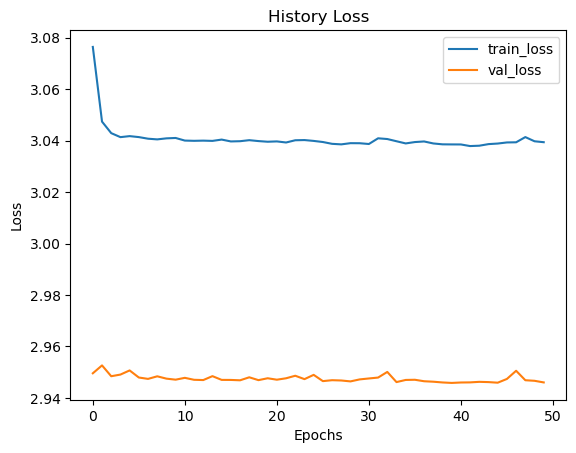

In [162]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('History Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

❓ **Question** ❓ Plot many true sequences, as well as their predictions, to visualize your model performance

In [0]:
# YOUR CODE HERE

🏁 **Congratulation**